# BIOEN 485 HW 1: Evaluating the Accuracy of Linearization
## Joanne Boysen

## Preliminaries


**Score**: 9.5/10
Overall, you did very well. I took off because of a small issue in your code.

In [ ]:
!pip install -q control
!pip install -q tellurium

import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

     |████████████████████████████████| 357 kB 5.1 MB/s 
     |████████████████████████████████| 121 kB 5.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 5.0 MB 43.6 MB/s 
     |████████████████████████████████| 54.8 MB 1.3 MB/s 
     |████████████████████████████████| 2.6 MB 27.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.6 MB/s 
     |████████████████████████████████| 2.1 MB 33.5 MB/s 
     |████████████████████████████████| 36.7 MB 1.3 MB/s 
     |████████████████████████████████| 3.2 MB 33.9 MB/s 
     |████████████████████████████████| 5.6 MB 22.7 MB/s 
     |████████████████████████████████| 6.9 MB 36.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Nonlinear Model

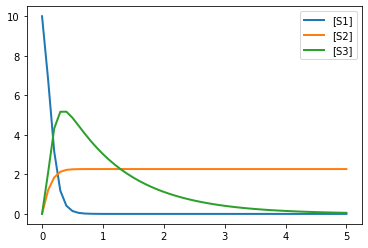

In [ ]:
NONLINEAR_MDL = """
JN1: S1 -> S2; k1*S1
JN2: S1 +  S2 -> 3 S3; k2*S1*S2
JN3: S3 -> ; k3*S3
JN4: 2 S1 + S3 -> S2; k4*S1*S3

k1 = 2
k2 = 1.5
k3 = 1
k4 = 0.5
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR_RR = te.loada(NONLINEAR_MDL)
NONLINEAR_DATA = NONLINEAR_RR.simulate()
NONLINEAR_RR.plot(NONLINEAR_DATA)

## Helpers

In [ ]:
def getStateDct(time, roadrunner=NONLINEAR_RR):
    """
    Retrieves the value of state at the specified time.
    Changes the time of the roadrunner.
    
    Parameters
    ----------
    time: float
    roadrunner: ExtendedRoadrunner
    
    Returns
    -------
    dict
        key: species name
        value: species value
    """
    roadrunner.reset()
    if time > 0:
        roadrunner.simulate(0, time)
    species_lst = roadrunner.getFloatingSpeciesIds()
    dct = {s: roadrunner[s] for s in species_lst}
    return dct
        
# Tests
dct = getStateDct(0)
assert(len(dct) == 3)
dct1 = getStateDct(1)  # Get different values at a different time
assert(all([dct[s] != dct1[s] for s in dct.keys()]))
print("OK!")

OK!


In [ ]:
def getStateValues(time, **kwargs):
    """
    Gets the values of state at the specified time.
    
    Parameters
    ----------
    time: float
    kwargs: dict
        keyword arguments for getStateDct
        
    Returns
    -------
    np.array
    """
    return np.array(list(getStateDct(time, **kwargs).values()))
        
# Tests
arr = getStateValues(0)
assert(isinstance(arr, np.ndarray))
assert(len(arr) == 3)
print("OK!")

OK!


In [ ]:
def plotRR(roadrunner=NONLINEAR_RR, is_plot=True):
    """
    Plots species from running a simulation.
    """
    roadrunner.reset()
    roadrunner.simulate(0, 5, 100)
    if is_plot:
        roadrunner.plot()

# Tests
plotRR(is_plot=False)
print("OK!")

OK!


## Q1 Construct a function that takes as input a time and a species name, and outputs a plot that compares a tellurium simulation of the species with a linearized model for the species

In [ ]:
op_points = [0, 0.3, 2]

In [ ]:
def linearApprox(op, roadrunner=NONLINEAR_RR):
  '''
  Constructs a linear approximation for nonlinear reaction network for given
  operating point.

  Parameters
  ----------
  op: float
    operating point
  species: string
  roadrunner: ExtendedRoadrunner

  Returns
  -------
  results: TimeResponseData
    time responses for linearized approximation of network
  '''
  # operating point and states
  op_vector = getStateValues(op)
  num_states = len(op_vector)
  # Simulate at the operating point
  roadrunner.reset()
  if op == 0:
    roadrunner.simulate(0)
  else:
    roadrunner.simulate(0, op)
  #  Extract the Jacobian
  A = roadrunner.getFullJacobian()
  
  # S1 as input
  B = np.array([1, 0, 0])
  B = np.reshape(B, (num_states, 1))

  # S3 as output
  C = np.array([0, 0, 1])
  C = np.reshape(C, (1, num_states))

  D = 0

  # Control objects
  NONLINEAR_SS_1_3 = control.StateSpace(A, B, C, D)

  # run simulation with transfer function object
  times = [0.1*v for v in range(51)]
  result = control.forced_response(NONLINEAR_SS_1_3, times, X0=getStateValues(0))

  return result

# TESTS
result=linearApprox(.5, roadrunner=NONLINEAR_RR)
# S1 intital value is 10
assert(result.x[0][0] == 10)
print('OK!')

  


OK!


In [ ]:
def compareModels(time, species, roadrunner=NONLINEAR_RR):
  '''
  Outputs a plot that compares a tellurium simulation of species with a
  linearized model for the species for given time at which the operating 
  points are evaluated

  Parameters
  ----------
  time: float
    time at which operating points are evaluated
  species: string
    floating species
  roadrunner: ExtendedRoadrunner

  '''
  # plot linear model
  species_number = int(species[1])
  result = linearApprox(time)
  plt.plot(result.t, result.x[species_number - 1], label='Linearized Model')

  # plot tellurium simulation data
  NONLINEAR_DATA = roadrunner.simulate()
  plt.plot(NONLINEAR_DATA[:,0], NONLINEAR_DATA[:, species_number],
           label='Tellurium Simulation')

  plt.xlabel('Time (s)')
  plt.ylabel(species)
  plt.legend()
  title = str(species + ' vs Time for Operating Point: ' + str(time) + 's')
  plt.title(title)

# TESTS
assert(len(result.t) == len(NONLINEAR_DATA[:,0]))
print('OK!')


OK!


## Q2 Use this function to analyze S2 and S3 for the operating points  0, 0.3, and 2.


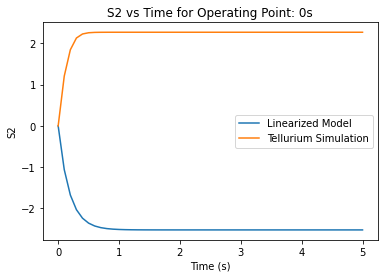

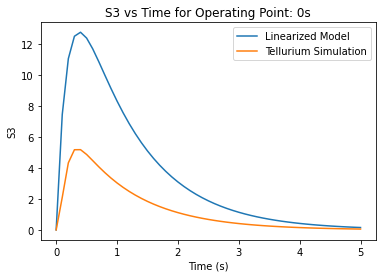

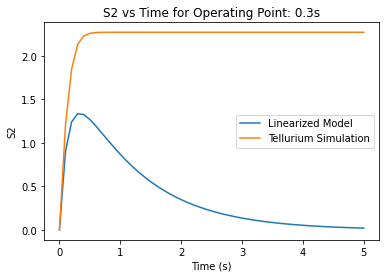

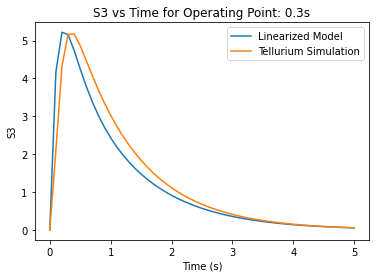

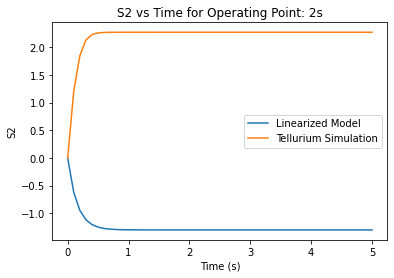

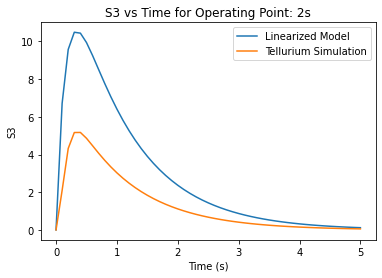

In [ ]:
for t in op_points:
  for species in ['S2', 'S3']:
    plt.figure()
    compareModels(t, species, roadrunner=NONLINEAR_RR)

## Q3 What are the largest discrepancies between the original simulation and the linearized models?

The linearized model does a poor job of simulating S2 concentrations. This is perhaps because when we construct a linear approximation for a model, it is focused on accurately modeling the inputs and outputs. As S2 is the intermediate species in this reaction, it is poorly modelled by the linearized model. 

S3 is best modelled by the linear approximation for the operating point at 0.3. For the other operating points, the model overshoots the maximum value. The operating point 0.3 likley best approximates this maximum value because it is close to where it occurs.